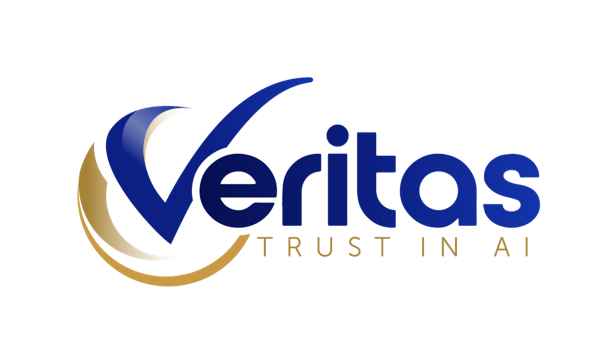

# Veritas Diagnosis Tool Demo : Base Classification 
    
<p>   
    The <b>Veritas toolkit</b> is comprised of diagnosis tool and assessment tool.
    This scenario is to build a propensity model and use diagnosis tool to evaluate model & produce
    the model artifact required by assessment tool to generate the fairness & transparency assessment report.
</p>    
<p>    
    Model used is a multi-class classification model. <br/>
    Steps to perform: <br/>
    1. Loading Data and Model <br/>  
    2. Fairness & Transparency Diagnosis <br/>
    3. Multiclass Fairness & Transparency Diagnosis <br/>
</p>

# 1. Loading Data and Model

## Importing Libraries 

In [1]:
import numpy as np
import pandas as pd
import pickle
import sys  
from pathlib import Path
# making veritas available in search path
sys.path.append('../../')
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import os
import sys
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

## Loading Data 

In [2]:
sys.path.append('./customer_marketing_example/')
pth = ''
#Load Phase 1-Customer Marketing Uplift Model Data, Results and Related Functions
file_prop = os.path.join(pth,'data',"mktg_uplift_acq_dict.pickle")
input_prop = open(file_prop, "rb")
cm_prop = pickle.load(input_prop)

In [3]:
#Propensity dataset
y_true = cm_prop["y_test"]
y_train = cm_prop["y_train"]
y_prob = pd.DataFrame(cm_prop["y_prob"], columns=['CN', 'CR', 'TN', 'TR'])
x_train = cm_prop["X_train"].drop(['ID'], axis = 1)
x_test = cm_prop["X_test"].drop(['ID'], axis = 1)

## Data Exploration

In [4]:
print("No of rows: {} \nNo. of columns: {}".format(x_train.shape[0],x_train.shape[1]))
x_train.head()

No of rows: 80000 
No. of columns: 6


,income,noproducts,didrespond,age,isfemale,isforeign
0,21851.709120,1,0,43.478362,0,1
1,66192.533929,3,0,47.779519,0,0
2,18829.532673,3,0,34.056453,1,0
3,71774.006240,7,0,46.640052,0,1
4,45153.751310,1,0,33.722548,0,0


Multiclass Label Distribution

<Axes: >

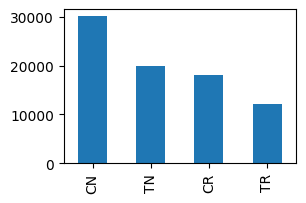

In [5]:
pd.Series(y_train).value_counts().plot.bar(figsize=(3,2))

## Loading Model

In [6]:
model_name = "base_classification" 
model_type = "classification"

clf = make_pipeline(
    StandardScaler(),    
    LogisticRegression(multi_class="multinomial", solver="lbfgs"),
)

clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

# 2. Fairness & Transparency Diagnosis

## Import Veritas Library

Veritas Library use case object creation includes two step. In the first step, Model_Container object is created with generic machine learning inputs. In the second step, use case object is created with Model_Container object and use case specific inputs. BaseClassification use case is showcased in this notebook.

In [7]:
from veritastool.model.modelwrapper import ModelWrapper
from veritastool.model.model_container import ModelContainer
from veritastool.usecases.base_classification import BaseClassification

#### Setup protected variable

In [8]:
p_grp = {'isforeign':[0], 'isfemale':[0]}

## Initializing Veritas Library

In [9]:
#Create Model Container 
container_bin = ModelContainer(y_true, p_grp, model_type, model_name, y_pred, y_prob, y_train, \
                           x_train=x_train, x_test=x_test, model_object=clf, \
                           pos_label=['TR','CR'], neg_label=['TN','CN'] ) 

<h5 align="center">Table 1: Model Container parameters   </h5>

| Var Name    | Category       |Sub-category   | Description   |  Value        |  Compulsory   |
| :---        |    :----:      |   :----:      |          ---: |          ---: |        ---: |
| y_true      | data           | testing       | test set labels| array([0, 1, 1, ..., 1])   |Yes|
| y_pred      | data           | testing       | test set predicted labels | array([0, 1, 1, ..., 1])   |Yes|
| y_prob      | data           | testing       | test set predicted probabilities | array([0.56, 0.33, 0.11, ..., 0.98])|No|
| x_test      | data           | testing       | test set features | -      |No|
| y_train     | data           | training      | train set labels      | array([0, 1, 1, ..., 1])   |No|
| x_train     | data           | training      | train set features |-      |No|
| p_grp       | protected vars |    -          | list of privileged groups| { 'isforeign': [0] , isfemale':[0],<br/>'isforeign\|isfemale':'maj_rest' }   |Yes|
| up_grp       | protected vars |    -          | list of privileged groups|    |No|
| model_obj   | model          |    -          | model to assess| -      |No|
| model_type  | model          |    -          | type of model | 'classification'    |Yes|
| model_name  | model          |    -          | name of model | 'propensity'   |No|
| pos_label  | target          |    -          | favourable label | ['TR', 'CR']   |No|
| neg_label  | target          |    -          | unfavourable label | ['TN', 'CN']   |No|



In [10]:
#Create Use Case Object
clf_obj_bin = BaseClassification(model_params = [container_bin], fair_threshold = 80, fair_metric_name = 'log_loss_parity', \
                                perf_metric_name = "tnr", tran_row_num = [12,42],tran_max_sample = 50, \
                                tran_pdp_feature = ['income','age'], tran_pdp_target = 'TR')                           

<h5 align="center">Table 2: Base Classification parameters   </h5>

| Var Name    | Category       | Description   |  Value        |Compulsory|
| :---        |    :----:      |          ---: |          ---: |---:|
| model_params| model containers | list of model containers | -  |Yes|
| fair_threshold | fairness metric thresolding |threshold used for assessment|floating value between 0 and 1 (treated as actual <br/> value) or 1 and 100 (treated as p%)   |No|
| fair_concern |fair_metric selection| for auto-suggestion: most concerned cohort| "eligible" or "inclusive" or "both" |No|
| fair_priority| fair_metric selection| for auto-suggestion: top priority to be for fairness assessment | "benefit" or "harm" |No|
| fair_impact  | fair_metric selection | for auto-suggestion: impact magnitude and type | "normal" or "significant" or "selective"   |No|
| fair_metric_type  | fair_metric selection | for auto-suggestion: type of metric | "difference" or "ratio"  |No|
| fair_metric_name      | metric name |primary fairness metric | "auto" or any of supported ones <br/> like "expected_harm"   |No|
| perf_metric_name      | metric name |primary performance metric |"expected_profit"   |Yes|
| tran_row_num      | transparency parameter |row number for local interpretability plot starting with 1 |list of integers   |No|
| tran_max_sample      | transparency parameter |sampling size for transparency analysis |float value between 0 and 1 (treated as <br/> percentage of rows)  or  int treated as #rows   |No|
| tran_pdp_feature      | transparency parameter |feature list for pdp plots |list of features   |No|
| tran_pdp_target      | transparency parameter |class label for pdp plots(required for multi-class model) |string |No|
| tran_max_display      | transparency parameter |#features to be displayed in the transparency plots |int    |No|
| tran_processed_data      | transparency parameter |sample dataframe for the analysis incase x_train is a string |dataframe    |No|
| tran_processed_label      | transparency parameter |list of y_train(s) for the given tran_processed_data |list    |No|






## Starting Fairness diagnosis

In [ ]:
clf_obj_bin.evaluate()

In [11]:
clf_obj_bin.tradeoff()

Tradeoff:   0%|          


----------------------------- 1. isforeign -----------------------------
Performance versus Fairness Trade-Off
	 Single Threshold
		Privileged/Unprivileged Threshold                 0.700
		Best balanced_acc*                                0.444
	 Separated Thresholds
		Privileged Threshold                              0.300
		Unprivileged Threshold                            0.301
		Best balanced_acc*                                0.460
	 Separated Thresholds under Neutral Fairness (0.001)
		Privileged Threshold                              0.300
		Unprivileged Threshold                            0.334
		Best balanced_acc*                                0.458
		*estimated by approximation, subject to the resolution of mesh grid

----------------------------- 2. isfemale  -----------------------------
Performance versus Fairness Trade-Off
	 Single Threshold
		Privileged/Unprivileged Threshold                 0.700
		Best balanced_acc*                                0.444
	 Separated

In [ ]:
clf_obj_bin.feature_importance()

In [ ]:
clf_obj_bin.rootcause()

In [ ]:
mitigated_bin = clf_obj_bin.mitigate(method=['threshold'])

## Starting Transparency Diagnosis

Running transparency for model 1        done      
     Data preparation                   done      
     Interpretability                   done      
     Partial dependence                 done      


Computing Permutation Importance:   0%|          

     Permutation importance             done      


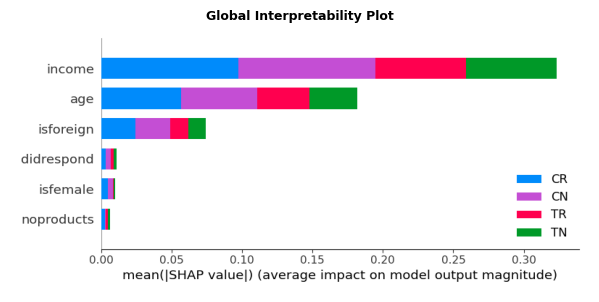

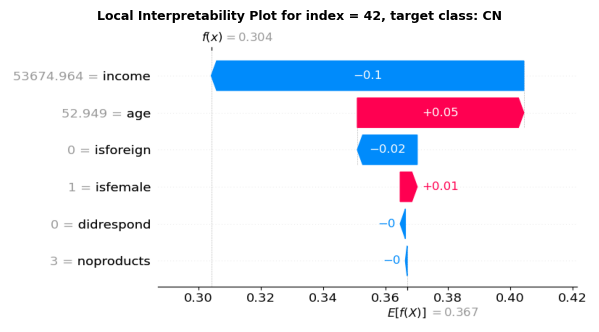

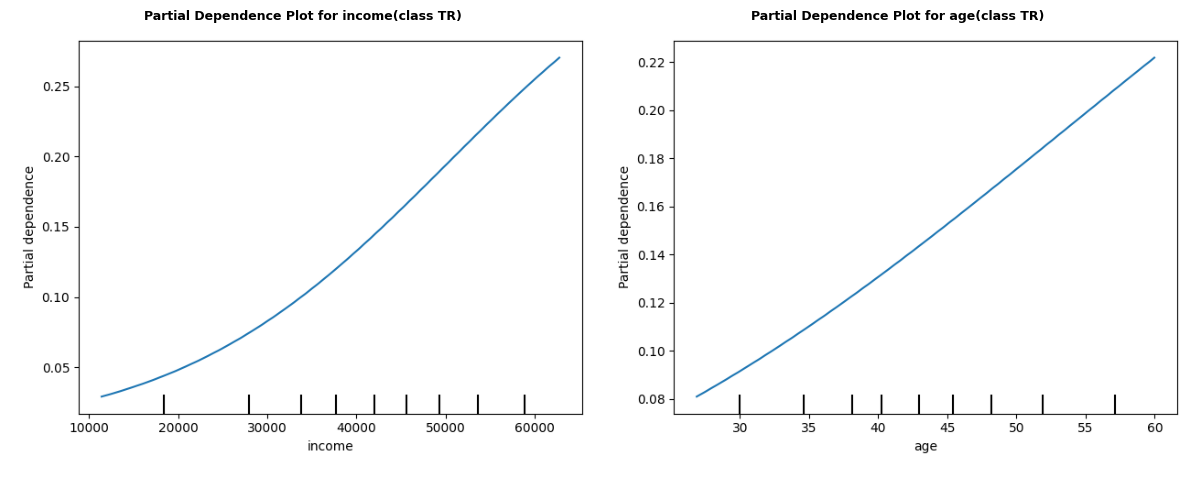

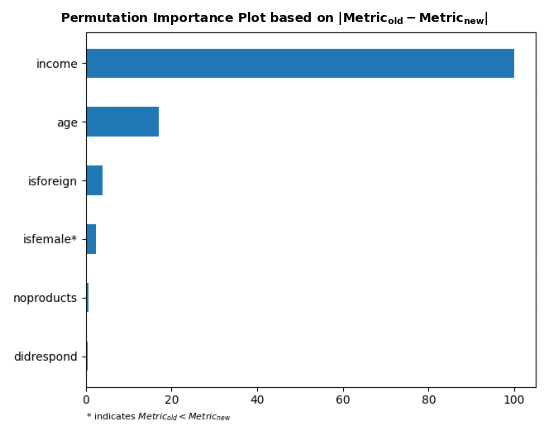

In [12]:
#run the entire transparency analysis
clf_obj_bin.explain()

<h5 align="center">Table 3: Transparency parameters   </h5>

| Var Name    | Description   |  Value        |Default|Compulsory|
| :---        |          ---: |          ---: |---:|---:|
| disable | disable any of the transparency analysis |list of valid inputs ['interpret','partial_dep','perm_imp']  |blank list |No|
| local_row_num |row number for local interpretability plot |integer   |last value of tran_row_num |No|
| model_num   |model for which assessment is required |1 or 2   |last model in model container |No|
| output      |boolean value for displaying the plots |True or False   |True |No|





In [ ]:
#get the local interpretability plot for specific row index
clf_obj_bin.explain(local_row_num = 12)

# Starting Multiclass Fairness and Transparency diagnosis

In [13]:
#Create Model Container 
container = ModelContainer(y_true,  p_grp, model_type, model_name, y_pred, y_prob, y_train, \
                           x_train=x_train, x_test=x_test, model_object=clf, \
                           pos_label = None)

In [16]:
#Create Use Case Object
clf_obj = BaseClassification(model_params = [container], fair_threshold = 80, fair_metric_name='log_loss_parity', \
                           perf_metric_name = "tnr", tran_row_num=[12,42], tran_max_sample=50, \
                           tran_pdp_feature = ['income','age'], tran_pdp_target='TR')                           

In [17]:
clf_obj.evaluate()

Evaluate performance:   0%|          


Class Distribution
	pos_label                                                              NA
	neg_label                                                              NA


Performance Metrics
	Selection Rate                                             0.250 +/- 0.000
	Accuracy                                                   0.417 +/- 0.009
	Balanced Accuracy                                          0.343 +/- 0.007
	Recall                                                     0.417 +/- 0.009
	Precision                                                  0.417 +/- 0.009
	F1 Score                                                   0.417 +/- 0.009
	True Negative Rate                                         0.806 +/- 0.003
	False Negative Rate                                        0.583 +/- 0.009
	Negative Predictive Value                                  0.806 +/- 0.003
	ROC AUC Score                                              0.362 +/- 0.007
	Log-loss                                       

<h5 align="center">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Table 3: Use of protected variable in model</h5>

|Fairness|Performace|Suggestion|
| -------- | ---------- | --------------- |
|Worse  |Worse	|Include|
|Better|Better|Exclude|
|Worse|Better|Examine Further|
|Better|Worse|Examine Further|

In [18]:
clf_obj.feature_importance()

Feature importance:   0%|          




--------------------------------------------------1: Fairness on Isforeign--------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------
|Removed Protected Variable    |tnr                      |log_loss_parity          |Fairness Conclusion |Suggestion        |
----------------------------------------------------------------------------------------------------------------------------
|isforeign                     |-0.002                   |0.479                    |unfair to fair (+)  |Examine Further   |
----------------------------------------------------------------------------------------------------------------------------
|isfemale                      |0.000                    |0.486                    |unfair to fair (+)  |Exclude           |
-------------------------------------------------------------------------------------------------------------------------

Correlation analysis :   0%|          


Partial correlation matrix (Most correlated features for isforeign, isfemale):


,isforeign,isfemale,noproducts,age,income
isforeign,1.000000,0.022928,0.089294,0.292067,0.272970
isfemale,0.022928,1.000000,0.172496,0.037134,0.467237
noproducts,0.089294,0.172496,1.000000,0.000000,0.448823
age,0.292067,0.037134,0.000000,1.000000,0.031726
income,0.272970,0.467237,0.448823,0.031726,1.000000


* No surrogate detected based on correlation analysis (threshold=0.7).


Running transparency for model 1        done      
     Interpretability                   done      
     Partial dependence                 done      


Computing Permutation Importance:   0%|          

     Permutation importance             done      


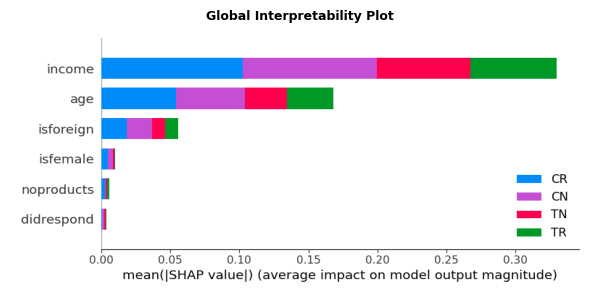

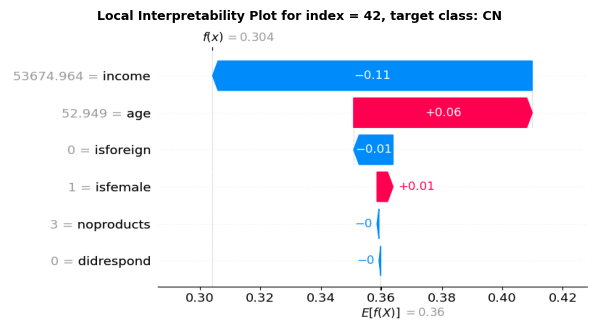

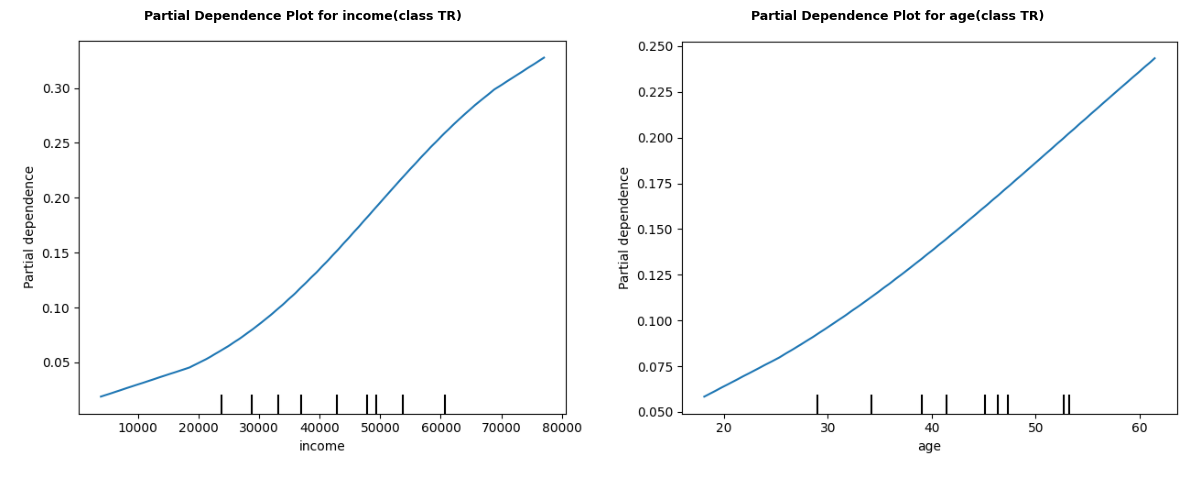

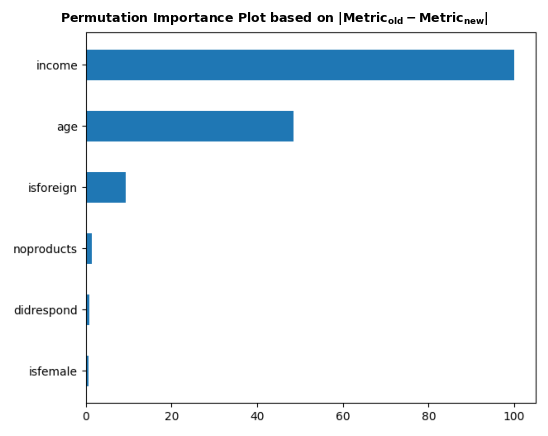

In [19]:
clf_obj.explain()

Root cause analysis:   0%|          



                             Top 10 contributors towards bias for class 'TR'    
                         Measured by SHAP-based Demographic Parity on 52 samples




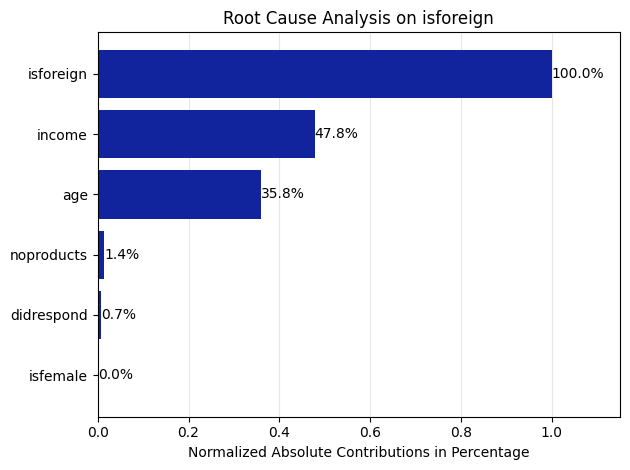

In [20]:
clf_obj.rootcause(p_var=['isforeign'])

In [21]:
mitigated = clf_obj.mitigate(p_var=['isforeign', 'isfemale'] , method=['reweigh'])

Bias mitigation :   0%|          


*Effective input for p_var = ['isforeign', 'isfemale']

                                   Reweighing                                   

--------------------------------------------------------------------------------
|isforeign, isfemale           |Label                  |Weight                 |
--------------------------------------------------------------------------------
|0, 0                          |CN                     |1.165                  |
--------------------------------------------------------------------------------
|0, 0                          |CR                     |0.807                  |
--------------------------------------------------------------------------------
|0, 0                          |TN                     |1.207                  |
--------------------------------------------------------------------------------
|0, 0                          |TR                     |0.783                  |
---------------------------------------------------

In [22]:
smpl_wght_mitg, _ =  mitigated['reweigh']

In [23]:
model_mitg = make_pipeline(
    StandardScaler(),    
    LogisticRegression(multi_class="multinomial", solver="lbfgs"),
)

model_mitg= model_mitg.fit(x_train, y_train, logisticregression__sample_weight =smpl_wght_mitg)
y_pred_mitg = model_mitg.predict(x_test)

y_prob_mitg = model_mitg.predict_proba(x_test)
y_prob_mitg = pd.DataFrame(y_prob_mitg, columns=['CN', 'CR', 'TN', 'TR'])


In [24]:
#Mitigated Fairness Assessment
container_mitg = ModelContainer(y_true,  p_grp, model_type, model_name, y_pred_mitg, y_prob_mitg, y_train, \
                           x_train=x_train, x_test=x_test, model_object=model_mitg, \
                           pos_label = None)

clf_obj_mitg = BaseClassification(model_params = [container_mitg], fair_threshold = 80, fair_metric_name ='log_loss_parity', \
                                perf_metric_name = "tnr")    

clf_obj_mitg.evaluate()

Evaluate performance:   0%|          


Class Distribution
	pos_label                                                              NA
	neg_label                                                              NA


Performance Metrics
	Selection Rate                                             0.250 +/- 0.000
	Accuracy                                                   0.411 +/- 0.010
	Balanced Accuracy                                          0.333 +/- 0.007
	Recall                                                     0.411 +/- 0.010
	Precision                                                  0.411 +/- 0.010
	F1 Score                                                   0.411 +/- 0.010
	True Negative Rate                                         0.804 +/- 0.003
	False Negative Rate                                        0.589 +/- 0.010
	Negative Predictive Value                                  0.804 +/- 0.003
	ROC AUC Score                                              0.694 +/- 0.006
	Log-loss                                       

## Compiling Results

In [ ]:
#compile fairness results
clf_obj_mitg.compile(disable=['feature_importance', 'explain'])